# Chapter 8 - Dimensionality Reduction

## Exercises

1. What are the main motivations for reducing a dataset's dimensionality? What are the main drawbacks?
Motivasi utama: mengurangi kompleksitas data, mempercepat komputasi, menghindari curse of dimensionality, dan visualisasi data. Kekurangan: kehilangan informasi dan interpretasi yang lebih sulit.

2. What is the curse of dimensionality?
Curse of dimensionality adalah fenomena dimana performa algoritma machine learning menurun ketika jumlah fitur/dimensi terlalu banyak dibandingkan jumlah sampel.

3. Once a dataset's dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?
Ya, bisa di-reverse menggunakan inverse transform, tapi akan ada loss of information karena kompresi data.

4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?
Tidak, PCA bekerja optimal untuk data linear. Untuk data nonlinear lebih baik menggunakan Kernel PCA.

5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?
Jumlah dimensi akan tergantung pada variance ratio dari komponen-komponennya, tapi akan jauh lebih sedikit dari 1000 dimensi asli.

6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?
- Vanilla PCA: dataset kecil dan linear
- Incremental PCA: dataset besar yang tidak muat di memory
- Randomized PCA: dataset sangat besar
- Kernel PCA: dataset nonlinear

7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?
Dengan melihat explained variance ratio, reconstruction error, dan performa downstream task.

8. Does it make any sense to chain two different dimensionality reduction algorithms?
Ya, bisa dilakukan tapi harus hati-hati karena bisa menyebabkan loss of information yang berlebihan.

In [1]:
import numpy as np
import os
np.random.seed(42)
import sklearn

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## PCA

In [3]:
np.random.seed(42)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### Principal Components

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

### Projecting Down to d Dimensions


In [7]:

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [8]:
X2D_using_svd = X2D

### Dengan sklearn

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [10]:

X2D[:5]

array([[ 0.690074  ,  0.36150744],
       [-1.39636097, -0.34497714],
       [-1.00728461,  0.35025708],
       [-0.2736333 ,  0.50516373],
       [ 0.91324535, -0.26290852]])

In [11]:
X2D_using_svd[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

In [12]:

np.allclose(X2D, -X2D_using_svd)

True

In [13]:
X3D_inv = pca.inverse_transform(X2D)


In [14]:
np.allclose(X3D_inv, X)


False

In [15]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))


np.float64(0.009421417196957218)

In [16]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])


In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)


True

In [18]:

pca.components_

array([[ 0.95250178,  0.24902446,  0.17529172],
       [-0.29267159,  0.9076305 ,  0.30091563]])

In [19]:

pca.explained_variance_ratio_

array([0.85406025, 0.13622918])

In [20]:

1 - pca.explained_variance_ratio_.sum()

np.float64(0.009710567616013521)

In [21]:

np.square(s) / np.square(s).sum()

array([0.85406025, 0.13622918, 0.00971057])

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

C:\Users\USER\AppData\Local\Temp\ipykernel_18832\441280184.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")


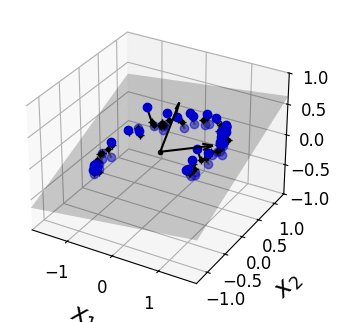

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

ax.quiver(0, 0, 0, C[0, 0], C[0, 1], C[0, 2], color='k', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, C[1, 0], C[1, 1], C[1, 2], color='k', arrow_length_ratio=0.2)

ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

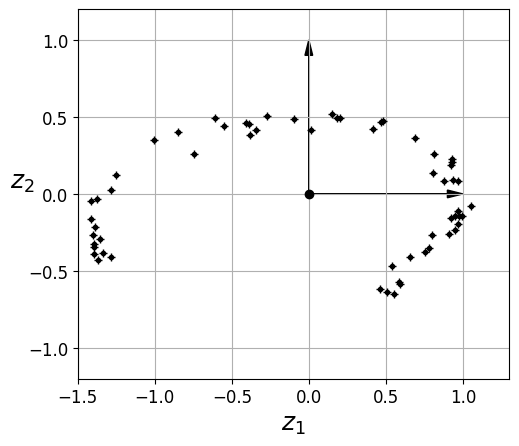

In [25]:

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

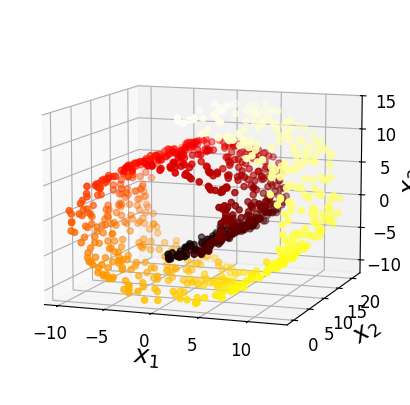

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

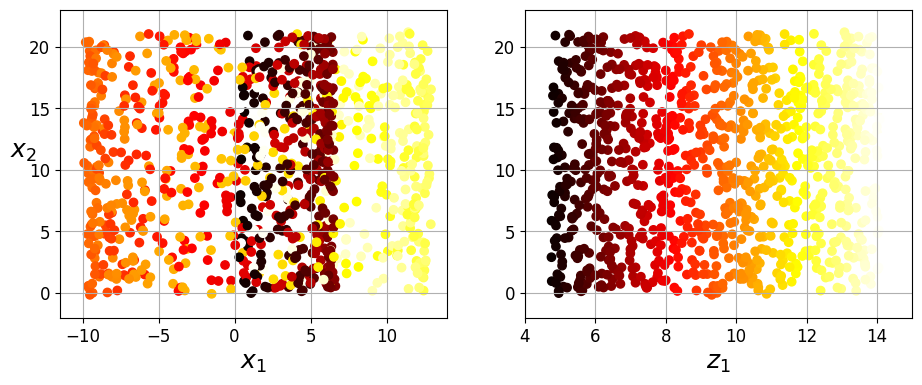

In [28]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

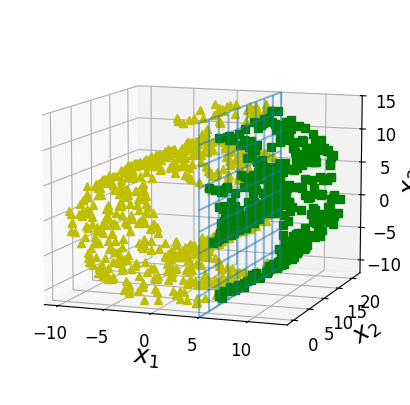

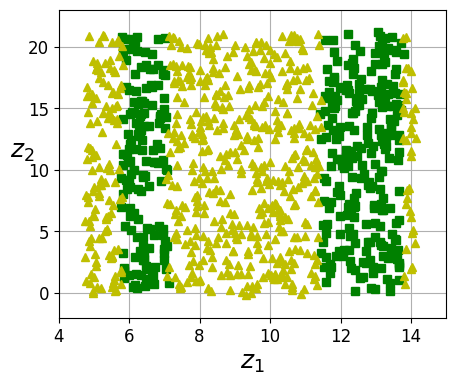

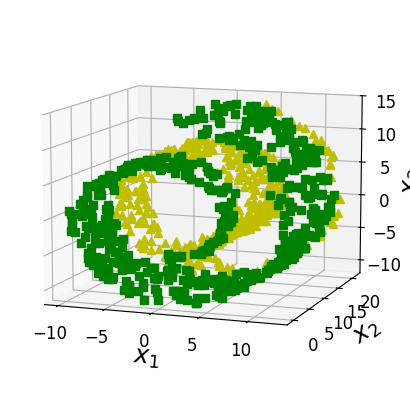

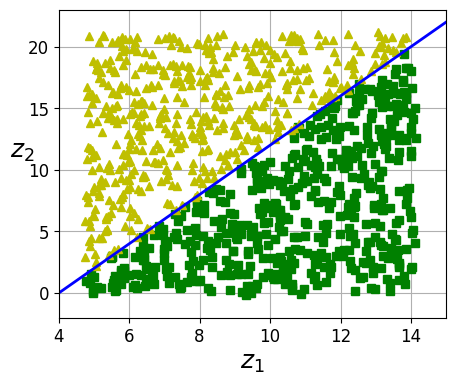

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

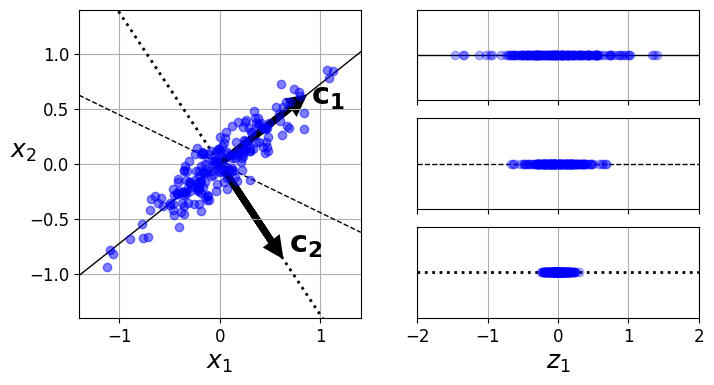

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

In [31]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [32]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

np.int64(154)

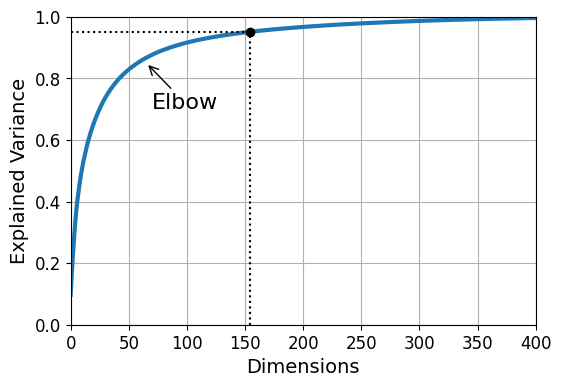

In [35]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [36]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [37]:

pca.n_components_

np.int64(154)

In [38]:

np.sum(pca.explained_variance_ratio_)

np.float64(0.9504334914295708)

In [39]:

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [40]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

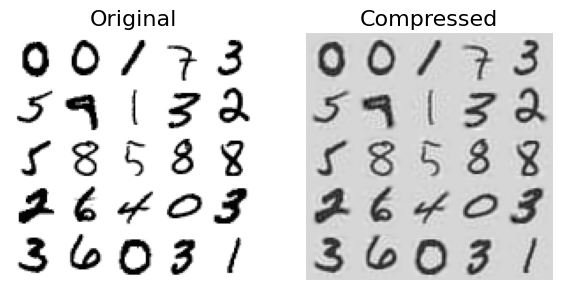

In [41]:

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


In [42]:

X_reduced_pca = X_reduced

In [43]:

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [44]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [45]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

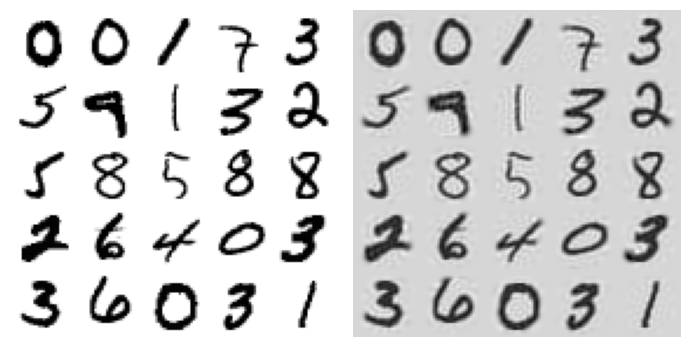

In [46]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [47]:
X_reduced_inc_pca = X_reduced


In [48]:
np.allclose(pca.mean_, inc_pca.mean_)


True

In [49]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)


False

In [50]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [51]:

del X_mm

In [52]:

X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

,n_components,154
,whiten,False
,copy,True
,batch_size,525


In [53]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 2.0 seconds
    Inc PCA: 8.1 seconds
    Rnd PCA: 0.5 seconds
n_components = 10
    PCA: 2.0 seconds
    Inc PCA: 8.6 seconds
    Rnd PCA: 0.6 seconds
n_components = 154
    PCA: 1.9 seconds
    Inc PCA: 10.7 seconds
    Rnd PCA: 1.4 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

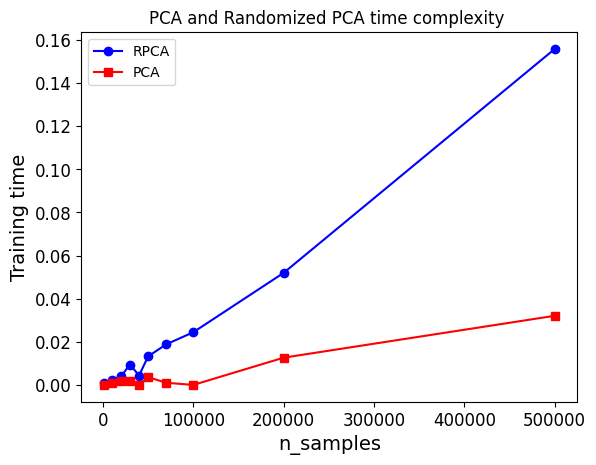

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

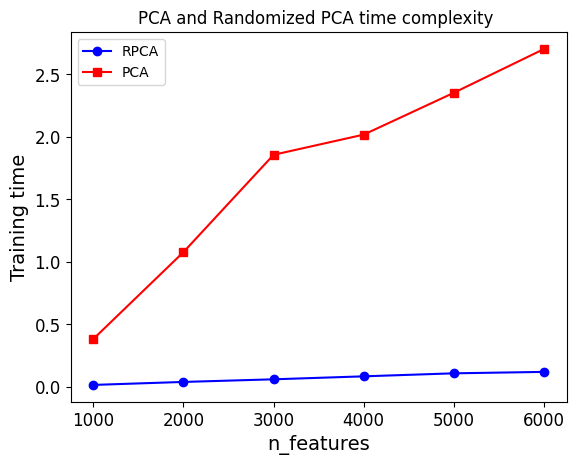

In [55]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

### Kernel PCA

In [56]:

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [57]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
C:\Users\USER\AppData\Local\Temp\ipykernel_18832\2768390099.py:10: SyntaxWarning: invalid escape sequence '\g'
  for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
C:\Users\USER\AppData\Local\Temp\ipykernel_18832\2768390099.py:10: SyntaxWarning: invalid escape sequence '\g'
  for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):


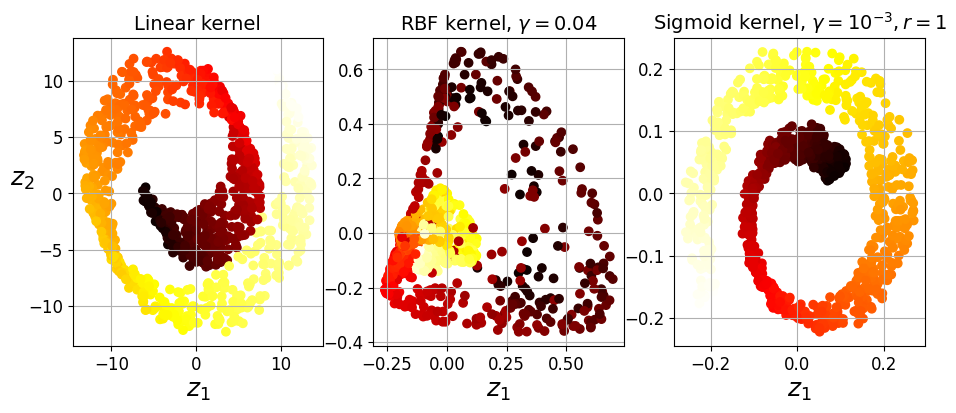

In [58]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

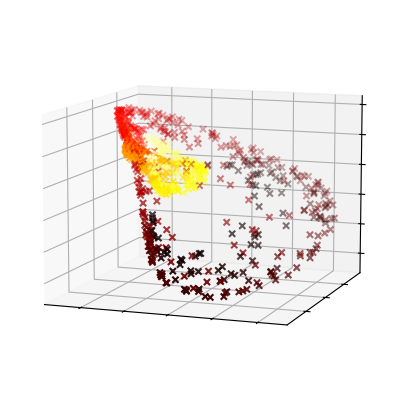

In [59]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

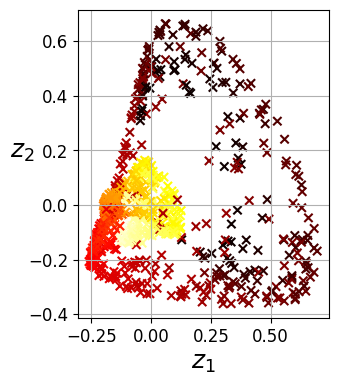

In [60]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'kpca__gamma': array([0.03 ..., 0.05 ]), 'kpca__kernel': ['rbf', 'sigmoid']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,2


In [62]:

print(grid_search.best_params_)

{'kpca__gamma': np.float64(0.043333333333333335), 'kpca__kernel': 'rbf'}


In [63]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [64]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

In [65]:

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [66]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

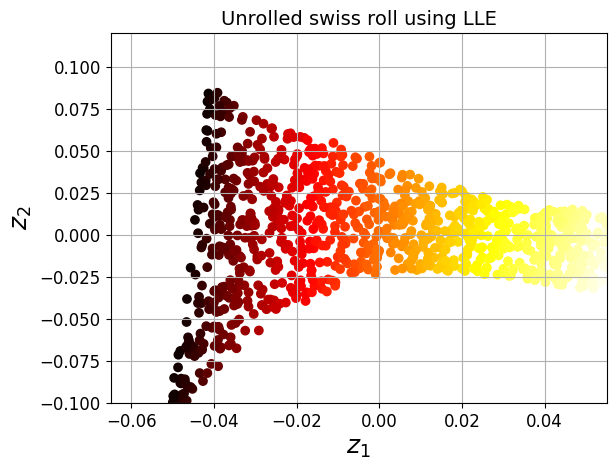

In [67]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

In [68]:

from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [69]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

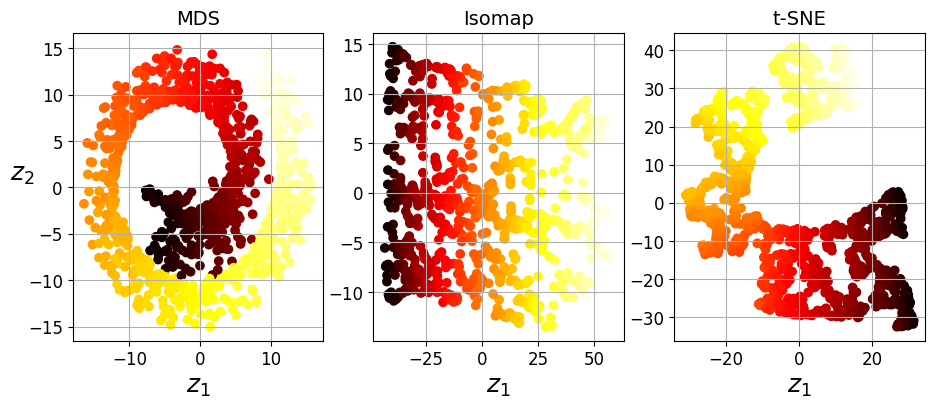

In [72]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Exercise Code

9. Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier?

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import time

X_train = mnist["data"][:60000]
y_train = mnist["target"][:60000]
X_test = mnist["data"][60000:]
y_test = mnist["target"][60000:]

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_clf.fit(X_train, y_train)
full_train_time = time.time() - start_time
print(f"Training time on full dataset: {full_train_time:.2f} seconds")

full_score = rf_clf.score(X_test, y_test)
print(f"Accuracy on full dataset: {full_score:.4f}")

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
print(f"Reduced dimensions from {X_train.shape[1]} to {X_train_reduced.shape[1]}")

rf_clf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_clf_reduced.fit(X_train_reduced, y_train)
reduced_train_time = time.time() - start_time
print(f"Training time on reduced dataset: {reduced_train_time:.2f} seconds")

reduced_score = rf_clf_reduced.score(X_test_reduced, y_test)
print(f"Accuracy on reduced dataset: {reduced_score:.4f}")

print(f"\nSpeedup factor: {full_train_time/reduced_train_time:.2f}x")
print(f"Accuracy difference: {reduced_score - full_score:.4f}")


Training time on full dataset: 29.08 seconds
Accuracy on full dataset: 0.9705
Reduced dimensions from 784 to 154
Training time on reduced dataset: 91.82 seconds
Accuracy on reduced dataset: 0.9488

Speedup factor: 0.32x
Accuracy difference: -0.0217


10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance's class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


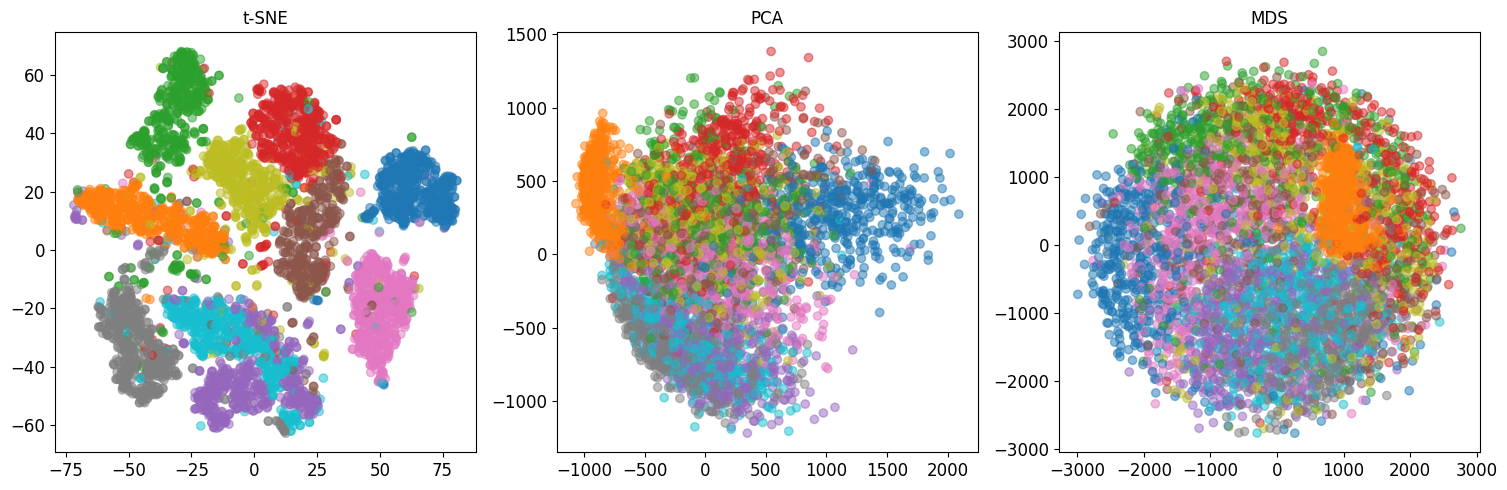

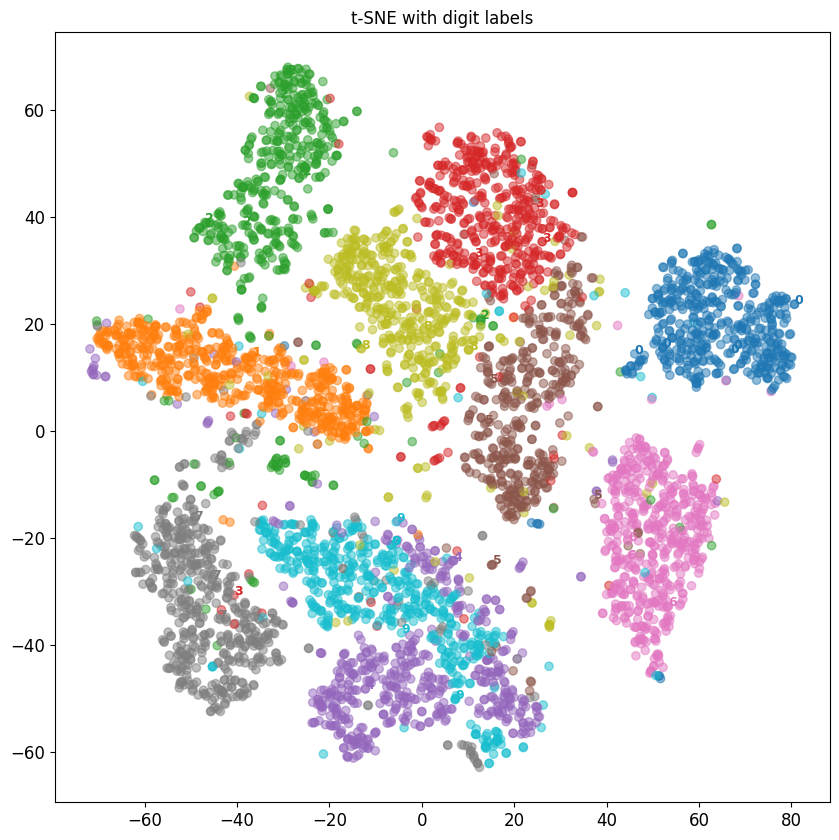

In [74]:
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding
import matplotlib.pyplot as plt
import numpy as np

n_samples = 5000
X_subset = X_train[:n_samples]
y_subset = y_train[:n_samples]

plt.figure(figsize=(15, 5))

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

plt.subplot(131)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='tab10', alpha=0.5)
plt.title('t-SNE')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='tab10', alpha=0.5)
plt.title('PCA')

mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_subset)

plt.subplot(133)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_subset, cmap='tab10', alpha=0.5)
plt.title('MDS')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='tab10', alpha=0.5)

for i in range(0, len(X_subset), 100):  # Plot every 100th digit
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y_subset[i]),
             color=plt.cm.tab10(y_subset[i] / 10),
             fontdict={'weight': 'bold', 'size': 9})

plt.title('t-SNE with digit labels')
plt.show()
